In [2]:
'''
재현성 보장 추가된 코드 + Epochs 50 -> 150으로 증가시켜 Physics Loss 충분히 활용될 수 있도록 변경 
'''

'\n재현성 보장 추가된 코드 + Epochs 50 -> 150으로 증가시켜 Physics Loss 충분히 활용될 수 있도록 변경 \n'

Using device: cuda

🔬 Ablation 1: Base (n_layers=3, Multi-scale, No SE)
  - Parameters: 71,174
[Model 1 (Base, L=2)] Epoch 25/150: Train Acc=98.46%, Test F1=0.9617, Test Acc=96.20% (Best F1: 0.9617, Best Acc: 96.20%)
[Model 1 (Base, L=2)] Epoch 50/150: Train Acc=99.52%, Test F1=0.9649, Test Acc=96.57% (Best F1: 0.9649, Best Acc: 96.57%)
[Model 1 (Base, L=2)] Epoch 75/150: Train Acc=99.73%, Test F1=0.9649, Test Acc=96.57% (Best F1: 0.9677, Best Acc: 96.84%)
[Model 1 (Base, L=2)] Epoch 100/150: Train Acc=99.89%, Test F1=0.9636, Test Acc=96.44% (Best F1: 0.9677, Best Acc: 96.84%)
[Model 1 (Base, L=2)] Epoch 125/150: Train Acc=99.92%, Test F1=0.9658, Test Acc=96.64% (Best F1: 0.9677, Best Acc: 96.84%)
[Model 1 (Base, L=2)] Epoch 150/150: Train Acc=99.97%, Test F1=0.9647, Test Acc=96.54% (Best F1: 0.9677, Best Acc: 96.84%)

🔬 Ablation 2: + SE Block
  - Parameters: 72,786
[Model 2 (+SE)] Epoch 25/150: Train Acc=98.34%, Test F1=0.9647, Test Acc=96.47% (Best F1: 0.9647, Best Acc: 96.47%)
[Mode

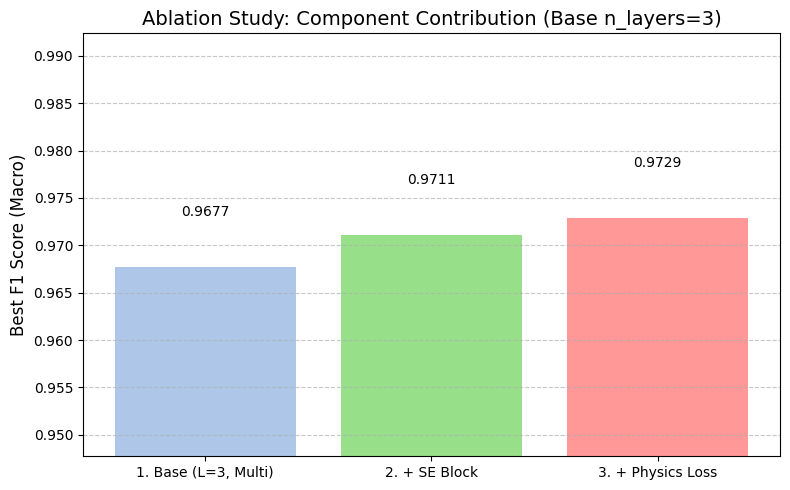

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import time
import random
from collections import deque
import matplotlib.pyplot as plt    
from sklearn.metrics import f1_score    

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# UCI-HAR 데이터 로드 
# ========================
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        base = Path(data_path) / split
        signals = []
        for sensor in ['body_acc', 'body_gyro', 'total_acc']:
            for axis in ['x', 'y', 'z']:
                file = base / 'Inertial Signals' / f'{sensor}_{axis}_{split}.txt'
                signals.append(np.loadtxt(file))

        self.X = np.stack(signals, axis=-1)
        self.y = np.loadtxt(base.parent / split / f'y_{split}.txt').astype(int) - 1

        try:
            self.subjects = np.loadtxt(base.parent / split / f'subject_{split}.txt').astype(int)
        except:
            self.subjects = np.ones(len(self.y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.LongTensor([self.y[idx]])[0],
                self.subjects[idx])

# ========================
# 🔥 Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features
        self.physics_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 6)
        )

    def forward(self, x, return_physics=False):
        x = x.transpose(1, 2)
        x_feat = self.input_proj(x)
        x_feat = self.large_kernel_conv(x_feat)
        x_feat = F.gelu(x_feat)
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = self.final_large_kernel(x_feat)
        x_feat = F.gelu(x_feat)
        if self.use_se:
            x_feat = self.se(x_feat)
        
        # 1. 분류 헤드
        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        if return_physics:
            # 2. 물리 헤드
            x_feat_transposed = x_feat.transpose(1, 2)
            physics = self.physics_head(x_feat_transposed)
            return logits, physics

        return logits

# ========================
# '물리 손실' 함수 
# ========================
def physics_loss(physics_pred, X_raw):
    acc_pred = physics_pred[:, :, :3]
    gyro_pred = physics_pred[:, :, 3:6]
    acc_true = X_raw[:, :, 0:3]
    gyro_true = X_raw[:, :, 3:6]
    return F.smooth_l1_loss(acc_pred, acc_true) + F.smooth_l1_loss(gyro_pred, gyro_true)

# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '기본' 학습 함수 (F1 Score 기준)
# ========================
def train_base(model, train_loader, test_loader, device, epochs, model_name="Base"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    best_f1 = 0.0
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            
            # --- 기본 학습 (Physics Loss 없음) ---
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            # ------------------------------------

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        scheduler.step()

        model.eval()
        test_correct, test_total = 0, 0
        all_preds = [] 
        all_y = []  

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                
                # --- 기본 추론 ---
                logits = model(X)
                # -----------------
                
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item() 
                test_total += y.size(0)           

                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())

        train_acc = 100 * correct / total
        test_f1 = f1_score(all_y, all_preds, average='macro',
                           labels=list(range(6)), zero_division=0)
        test_acc = 100 * test_correct / test_total

        best_f1 = max(best_f1, test_f1) 
        best_acc = max(best_acc, test_acc)

        if (epoch + 1) % 25 == 0 or epoch == epochs - 1:
            print(f'[{model_name}] Epoch {epoch+1:02d}/{epochs}: Train Acc={train_acc:.2f}%, Test F1={test_f1:.4f}, Test Acc={test_acc:.2f}% (Best F1: {best_f1:.4f}, Best Acc: {best_acc:.2f}%)')

    return best_f1, best_acc 

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, epochs=50, lambda_phys=0.05, log_every=1):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    best_f1, best_acc = 0.0, 0.0
    # 손실 히스토리 저장 (에폭 단위)
    history = {
        "train_ce": [], "train_phys": [], "train_total": [],
        "test_acc": [], "test_f1": []
    }

    for epoch in range(1, epochs+1):
        model.train()
        # 에폭 누적용
        ce_sum, phys_sum, total_sum = 0.0, 0.0, 0.0
        correct, total = 0, 0

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, physics = model(X, return_physics=True)
            loss_ce = F.cross_entropy(logits, y)
            loss_phys = physics_loss(physics, X)

            loss = loss_ce + lambda_phys * loss_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # 누적 (주의: .item()으로 숫자화)
            ce_sum   += loss_ce.item()
            phys_sum += loss_phys.item()
            total_sum += loss.item()

            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

        scheduler.step()

        # 에폭 평균
        n_batches = len(train_loader)
        ce_avg   = ce_sum / n_batches
        phys_avg = phys_sum / n_batches
        total_avg = total_sum / n_batches
        train_acc = 100.0 * correct / total

        # ====== 평가 ======
        model.eval()
        test_correct, test_total = 0, 0
        all_preds, all_y = [], []
        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X, return_physics=False)
                preds = logits.argmax(1)
                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(6)),
                           average='macro', zero_division=0)
        best_f1 = max(best_f1, test_f1)
        best_acc = max(best_acc, test_acc)

        # 로그 & 히스토리
        history["train_ce"].append(ce_avg)
        history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg)
        history["test_acc"].append(test_acc)
        history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics] Epoch {epoch:03d}/{epochs} | "
                  f"Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ={lambda_phys}) | "
                  f"Total={total_avg:.4f} || "
                  f"Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history


# ========================
# 시각화 함수
# ========================
def plot_results(results_dict):
    print("\n" + "="*90) # ⭐️ 너비 조절
    print("Ablation Study 최종 요약 (n_layers=3 기준)")
    print("="*90) # ⭐️ 너비 조절
    
    print(f"{'Model':<35} | {'Best Test F1':>25} | {'Best Test Acc (%)':>25}")
    print("-" * 89) 
    
    # 딕셔너리에서 F1과 Acc를 모두 꺼내서 출력
    for name, metrics in results_dict.items():
        print(f"{name:<35} | {metrics['f1']:>25.4f} | {metrics['acc']:>25.2f}")
    print("-" * 89)
    print("="*90)

    # --- 시각화 (F1 Score 기준) ---
    names = list(results_dict.keys())
    scores_f1 = [metrics['f1'] for metrics in results_dict.values()]
    
    plt.figure(figsize=(8, 5)) # 그래프 크기 조절
    colors = ['#AEC7E8', '#98DF8A', '#FF9896'] # 3가지 색상
    bars = plt.bar(names, scores_f1, color=colors)
    plt.ylabel('Best F1 Score (Macro)', fontsize=12)
    plt.title('Ablation Study: Component Contribution (Base n_layers=3)', fontsize=14)
    plt.xticks(rotation=0, ha='center')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=10)
        
    min_score = min(scores_f1) if scores_f1 else 0.9 # 최소값 0.9로 가정
    plt.ylim(bottom=max(0, min_score - 0.02), top=max(scores_f1) * 1.02 if scores_f1 else 1.0) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    data_path = 'C://Users/park9/ModernTCN_Physics/data'

    try:
        train_ds = UCIHARDataset(data_path, split='train')
        test_ds = UCIHARDataset(data_path, split='test')
    except FileNotFoundError:
        print(f"Error: 데이터셋을 찾을 수 없습니다. 'data_path' 변수를 수정하세요.")
        print(f"현재 경로: {data_path}")
        return

    def compute_train_stats(ds):
        # ds.X: numpy (N, T, C)
        X = torch.from_numpy(ds.X)             # (N, T, 9) float64일 수 있음
        X = X.float()
        mean = X.mean(dim=(0,1), keepdim=True) # (1,1,C)
        std  = X.std(dim=(0,1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(train_ds)

    def make_loaders(train_ds, test_ds, mean, std, batch_size=64, seed=42):
        def collate_norm(batch):
            X, y, s = zip(*batch)
            X = torch.stack(X, dim=0).float()
            X = (X - mean) / std
            y = torch.tensor(y, dtype=torch.long)
            s = torch.tensor(s, dtype=torch.long)
            return X, y, s

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_ds, batch_size=batch_size, shuffle=True,
            generator=g, num_workers=0, drop_last=True,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        test_loader = DataLoader(
            test_ds, batch_size=batch_size, shuffle=False,
            num_workers=0, drop_last=False,
            pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
        )
        return train_loader, test_loader
    
    EPOCHS = 150 # 공통 Epoch
    results = {} # 결과 저장 딕셔너리

    # ---
    # 🔬 1. New Base (n_layers=3, Multi-scale, No SE, No Physics)
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 1: Base (n_layers=3, Multi-scale, No SE)")
    print("="*60)
    set_seed(42)
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    model1 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=6,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.1,
        use_se=False         # ⭐️ SE OFF
    ).to(device)
    print(f"  - Parameters: {get_n_params(model1)}")
    f1_1, acc_1 = train_base(model1, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 1 (Base, L=2)")
    results['1. Base (L=3, Multi)'] = {'f1': f1_1, 'acc': acc_1}

    # ---
    # 🔬 2. + SE Block
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 2: + SE Block")
    print("="*60)
    set_seed(42)
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    model2 = BaseModernTCNHAR(
        input_dim=9, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=6,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.1,
        use_se=True          # ⭐️ SE ON
    ).to(device)
    print(f"  - Parameters: {get_n_params(model2)}")
    f1_2, acc_2 = train_base(model2, train_loader, test_loader, device, epochs=EPOCHS, model_name="Model 2 (+SE)")
    results['2. + SE Block'] = {'f1': f1_2, 'acc': acc_2}
    
    # ---
    # 🔬 3. + Physics Loss (Full Model)
    # ---
    print("\n" + "="*60)
    print("🔬 Ablation 3: + SE Block + Physics Loss")
    print("="*60)
    set_seed(42)
    train_loader, test_loader = make_loaders(train_ds, test_ds, mean, std, seed=42)
    model3 = PhysicsModernTCNHAR( # ⭐️ Physics 모델 사용
        input_dim=9, hidden_dim=64, n_layers=3, # ⭐️ n_layers=2
        n_classes=6,
        kernel_sizes=[3, 7], # ⭐️ Multi-scale 유지
        large_kernel=19, 
        dropout=0.1,
        use_se=True          # ⭐️ SE ON
    ).to(device)
    print(f"  - Parameters: {get_n_params(model3)}")
    f1_3, acc_3, hist = train_physics(model3, train_loader, test_loader, device,
                                      epochs=EPOCHS, lambda_phys=0.05, log_every=25) # ⭐️ train_physics 사용
    results['3. + Physics Loss'] = {'f1': f1_3, 'acc': acc_3}

    plot_results(results)


if __name__ == '__main__':
    main()